In [52]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

In [54]:
video_path = "crow_and_squirrel.mp4"

In [ ]:
cap = cv2.VideoCapture(video_path)
frames = []
for _ in range(2000):
    ret, frame = cap.read()
    if not ret:
        break
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    frames.append(gray_frame)
cap.release()
background = np.median(np.stack(frames), axis=0).astype(np.uint8)

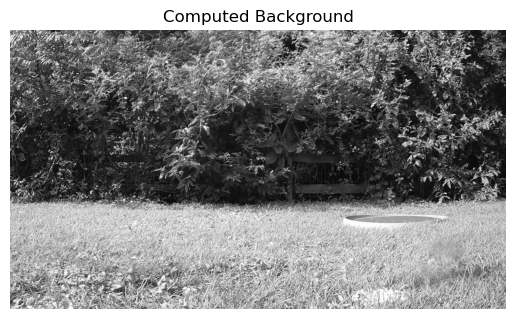

In [104]:
plt.imshow(background)
plt.title("Computed Background")
plt.axis("off")
plt.show()

In [19]:
cv2.imwrite("background.png", background)

True

In [122]:
background = cv2.imread("background.png", cv2.COLOR_BGR2GRAY)

In [136]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 9))
kernel2 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
kernel3 = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 9))

In [138]:
def motion_mask(background, gray_frame):
    diff = cv2.absdiff(background, gray_frame)
    diff = cv2.GaussianBlur(diff, (5, 5), 0)
    _, mask = cv2.threshold(diff, 15, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    #mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    #mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel3)
    #mask = cv2.morphologyEx(mask, cv2.MORPH_GRADIENT, kernel)
    #mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel3)
    #mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel2)    
    
    
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel2)
    mask_top = cv2.morphologyEx(mask, cv2.MORPH_TOPHAT, kernel2)
    mask_top = cv2.morphologyEx(mask, cv2.MORPH_DILATE, kernel3)
    mask_top = cv2.morphologyEx(mask_top, cv2.MORPH_CLOSE, kernel3)
    mask_black = cv2.morphologyEx(mask, cv2.MORPH_BLACKHAT, kernel3)
    mask_black = cv2.morphologyEx(mask_black, cv2.MORPH_DILATE, kernel2)
    mask = cv2.bitwise_and(mask, mask_top)
    mask = cv2.bitwise_or(mask, mask_black)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel3)
    mask = cv2.morphologyEx(mask, cv2.MORPH_DILATE, kernel2)
    #mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel2)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    #mask = cv2.morphologyEx(mask, cv2.MORPH_GRADIENT, kernel3)
    
    return mask
    

In [110]:
def make_box(img, bbox, color):
    p1 = (bbox[0], bbox[1])
    p2 = (bbox[0] + bbox[2], bbox[1] + bbox[3])
    cv2.rectangle(img, p1, p2, color, 2, 1)

In [519]:
cap = cv2.VideoCapture(video_path)
ret, frame = cap.read()
frame_count = 0
annotated_video_path = "resultat.mp4"
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
annotated_out = cv2.VideoWriter(annotated_video_path, fourcc, fps, (frame_width, frame_height))

In [520]:
while frame_count < 200000:
    ret, frame = cap.read()
    if not ret:
        break
    frame_count += 1
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    mask = motion_mask(background, frame_gray)

    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if frame_count:
        for contour in contours:
            area = cv2.contourArea(contour)
            perimeter = cv2.arcLength(contour, True)
            x, y, w, h = cv2.boundingRect(contour)
            aspect_ratio = w / h
            frame_area = frame.shape[0] * frame.shape[1]
            min_area = 0.005 * frame_area
            if area > min_area and perimeter > 65 and 0.5 < aspect_ratio < 3:
                if area >= 900:
                    bbox = cv2.boundingRect(contour)
                    make_box(frame, bbox, (0, 255, 0))

    annotated_out.write(frame)
cap.release()
annotated_out.release()

In [509]:
cap = cv2.VideoCapture(video_path)
ret, frame = cap.read()
frame_count = 0
binary_video_path = "resultat_b.mp4"
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
binary_out = cv2.VideoWriter(binary_video_path, fourcc, fps, (frame_width, frame_height), isColor=False)

In [510]:
while frame_count < 200000:
    ret, frame = cap.read()
    if not ret:
        break
    frame_count += 1
    hsv_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv_frame)
    shadow_mask = (s < 50) & (v < 120)
    shadow_mask = shadow_mask.astype(np.uint8) * 255
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    frame_gray[shadow_mask > 0] = background[shadow_mask > 0]
    mask = motion_mask(background, frame_gray)
    binary_out.write(mask)
cap.release()
binary_out.release()

In [83]:
import torch
import torchvision.transforms as transforms
from torchvision.models import efficientnet_b0
from torchvision.models import EfficientNet_B0_Weights

In [86]:
def load_model(weights_path):
    model = efficientnet_b0(weights=None, num_classes=2)
    model.load_state_dict(torch.load(weights_path, map_location=torch.device('cpu'), weights_only=True))
    model.eval()
    return model

In [88]:
weights_path = "efficientnet_crows_and_squirrels.pth"
model = load_model(weights_path)

In [89]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


In [92]:
def classify_object(model, roi, transform):
    input_tensor = transform(roi).unsqueeze(0)
    with torch.no_grad():
        outputs = model(input_tensor)
        _, predicted = torch.max(outputs, 1)
        probabilities = torch.softmax(outputs, dim=1)
        max_confidence, _ = torch.max(probabilities, dim=1)
    #if max_confidence.item() < confidence_threshold:
    #    return "Noise", max_confidence.item()
    if predicted.item() == 0:
        return "Crow", max_confidence.item()
    elif predicted.item() == 1:
        return "Squirrel", max_confidence.item()        

In [594]:
cap = cv2.VideoCapture(video_path)
ret, frame = cap.read()
frame_count = 0
neural_video_path = "resultat_n.mp4"
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
neural_out = cv2.VideoWriter(neural_video_path, fourcc, fps, (frame_width, frame_height))

In [595]:
while frame_count < 200000:
    ret, frame = cap.read()
    if not ret:
        break
    frame_count += 1
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    mask = motion_mask(background, frame_gray)

    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if frame_count:
        for contour in contours:
            area = cv2.contourArea(contour)
            perimeter = cv2.arcLength(contour, True)
            x, y, w, h = cv2.boundingRect(contour)
            aspect_ratio = w / h
            frame_area = frame.shape[0] * frame.shape[1]
            min_area = 0.005 * frame_area
            if area > min_area and perimeter > 65 and 0.5 < aspect_ratio < 3:
                if area >= 300:
                    bbox = cv2.boundingRect(contour)
                    prep_roi = frame[y:y + h, x:x + w]
                    roi = cv2.cvtColor(prep_roi, cv2.COLOR_BGR2RGB)
                    label, confidence = classify_object(model, roi, transform)
                    if confidence > 0.9:
                        make_box(frame, bbox, (0, 255, 0))
                        cv2.putText(frame, f"{label} ({confidence:.2f})", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
                        enhanced_roi = cv2.convertScaleAbs(prep_roi, alpha=1.5, beta=50)
                        frame[y:y + h, x:x + w] = enhanced_roi
                

    neural_out.write(frame)
cap.release()
neural_out.release()

### Hungarian Algorithm

In [172]:
from scipy.optimize import linear_sum_assignment

In [244]:
class Track:
    def __init__(self, track_id, bbox, confidence, label):
        self.track_id = track_id
        self.bbox = bbox
        self.confidence = confidence
        self.label = label
        self.missed_frames = 0
        self.predicted_bbox = bbox 

In [246]:
def calculate_iou(box1, box2):
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2
    xi1 = max(x1, x2)
    yi1 = max(y1, y2)
    xi2 = min(x1 + w1, x2 + w2)
    yi2 = min(y1 + h1, y2 + h2)

    inter_width = max(0, xi2 - xi1)
    inter_height = max(0, yi2 - yi1)
    inter_area = inter_width * inter_height

    box1_area = w1 * h1
    box2_area = w2 * h2
    union_area = box1_area + box2_area - inter_area

    if union_area == 0:
        return 0
        
    iou = inter_area / union_area
    return iou

In [248]:
class Tracker:
    def __init__(self, max_missed_frames=30, iou_threshold=0.3):
        self.tracks = []
        self.next_id = 0
        self.max_missed_frames = max_missed_frames
        self.iou_threshold = iou_threshold

    def update(self, detections, confidences, labels):
        if len(self.tracks) == 0:
            for bbox, conf, label in zip(detections, confidences, labels):
                self.tracks.append(Track(self.next_id, bbox, conf, label))
                self.next_id += 1
            return

        cost_matrix = []
        for track in self.tracks:
            row = []
            for bbox in detections:
                iou = calculate_iou(track.bbox, bbox)
                row.append(1 - iou)
            cost_matrix.append(row)
        cost_matrix = np.array(cost_matrix)

        track_indices, detection_indices = linear_sum_assignment(cost_matrix)

        unmatched_tracks = set(range(len(self.tracks)))
        unmatched_detections = set(range(len(detections)))

        for t_idx, d_idx in zip(track_indices, detection_indices):
            if 1 - cost_matrix[t_idx, d_idx] >= self.iou_threshold:
                self.tracks[t_idx].bbox = detections[d_idx]
                self.tracks[t_idx].confidence = confidences[d_idx]
                self.tracks[t_idx].missed_frames = 0 
                unmatched_tracks.discard(t_idx)
                unmatched_detections.discard(d_idx)
            else:
                unmatched_tracks.add(t_idx)
                unmatched_detections.add(d_idx)

        for t_idx in unmatched_tracks:
            self.tracks[t_idx].missed_frames += 1

        self.tracks = [t for t in self.tracks if t.missed_frames <= self.max_missed_frames]
        
        for d_idx in unmatched_detections:
            self.tracks.append(Track(self.next_id, detections[d_idx], confidences[d_idx], labels[d_idx]))
            self.next_id += 1


In [250]:
cap = cv2.VideoCapture(video_path)
ret, frame = cap.read()
frame_count = 0
neuralh_video_path = "resultat_nh.mp4"
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
neuralh_out = cv2.VideoWriter(neuralh_video_path, fourcc, fps, (frame_width, frame_height))

In [252]:
tracker = Tracker(max_missed_frames=15, iou_threshold=0.3)

while frame_count < 200000:
    ret, frame = cap.read()
    if not ret:
        break
    frame_count += 1
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    mask = motion_mask(background, frame_gray)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    detections = []
    confidences = []
    labels = []
    for contour in contours:
        area = cv2.contourArea(contour)
        perimeter = cv2.arcLength(contour, True)
        x, y, w, h = cv2.boundingRect(contour)
        aspect_ratio = w / h
        frame_area = frame.shape[0] * frame.shape[1]
        min_area = 0.005 * frame_area
        if area > min_area and perimeter > 65 and 0.5 < aspect_ratio < 3:
            if area >= 300:
                bbox = (x, y, w, h)
                prep_roi = frame[y:y + h, x:x + w]
                roi = cv2.cvtColor(prep_roi, cv2.COLOR_BGR2RGB)
                label, confidence = classify_object(model, roi, transform)
                if confidence > 0.9:
                    detections.append(bbox)
                    confidences.append(confidence)
                    labels.append(label)
    tracker.update(detections, confidences, labels)
    for track in tracker.tracks:
        x, y, w, h = track.bbox
        cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(frame, f"ID: {track.track_id}, Class: {track.label}, Conf: {track.confidence:.2f}", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)
        enhanced_roi = cv2.convertScaleAbs(frame[y:y + h, x:x + w], alpha=1.5, beta=50)
        frame[y:y + h, x:x + w] = enhanced_roi
    
    neuralh_out.write(frame)
cap.release()
neuralh_out.release()
